In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/dataset.zip

In [ ]:
!pip install keras-tuner

In [ ]:
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
# Define the input size of images in your dataset
img_width, img_height = 256, 256

# Define the paths to your dataset folders
train_dir = 'dataset2/train'
val_dir = 'dataset2/val'

# Define the batch size and number of epochs for training
batch_size = 32
num_epochs = 60

# Define the number of classes in your dataset
num_classes = 3

In [ ]:
# Create an instance of the ImageDataGenerator class for data augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Create an instance of the ImageDataGenerator class for validation data
val_data_gen = ImageDataGenerator(rescale=1./255)

# Generate the training data from the train directory using the train data generator
train_data = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Generate the validation data from the validation directory using the validation data generator
val_data = val_data_gen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 30000 images belonging to 3 classes.
Found 7500 images belonging to 3 classes.


In [ ]:
from kerastuner.tuners import RandomSearch

<ipython-input-18-94471a811b41>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
input_shape = (256, 256, 3)

def build_model(hp):
    base_model = InceptionV3(input_shape=input_shape,weights='imagenet', include_top=False)
    for layer in base_model.layers[:249]:
       layer.trainable = False
    for layer in base_model.layers[249:]:
       layer.trainable = True
    x = base_model.output
    x = Flatten()(x)
    x = Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.5))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3), momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='inceptionv3_tuner')

inceptionv3_history = tuner.search(train_data, validation_data=val_data, epochs=num_epochs, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

best_model = tuner.get_best_models(num_models=1)[0]

87910968/87910968 [==============================] - 3s 0us/step

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
64                |?                 |dense_units
0.4               |?                 |dropout_rate
1.6061e-05        |?                 |learning_rate

Epoch 1/60
938/938 [==============================] - 612s 635ms/step - loss: 1.1134 - accuracy: 0.3467 - val_loss: 1.0924 - val_accuracy: 0.3852
Epoch 2/60
938/938 [==============================] - 573s 610ms/step - loss: 1.0939 - accuracy: 0.3610 - val_loss: 1.0797 - val_accuracy: 0.3957
Epoch 3/60
938/938 [==============================] - 569s 607ms/step - loss: 1.0885 - accuracy: 0.3770 - val_loss: 1.0694 - val_accuracy: 0.4207
Epoch 4/60
938/938 [==============================] - 516s 550ms/step - loss: 1.0834 - accuracy: 0.3856 - val_loss: 1.0561 - val_accuracy: 0.4304
Epoch 5/60
938/938 [==============================] - 518s 553ms/step - loss: 1.0746 - accuracy: 0.3995 - val_loss: 1

In [ ]:
input_dir = 'dataset/val/vort'
output_dir = 'dataset2/val/vort'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    if filename.endswith(".npy"):
        # Load the .npy file
        image = np.load(os.path.join(input_dir, filename))
        # Reshape the image and convert to uint8
        image = np.squeeze(image)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        # Save the image as a .jpg file
        output_path = os.path.join(
            output_dir, os.path.splitext(filename)[0] + ".jpg")
        cv2.imwrite(output_path, image)


Number of images in the train set :  30000
Number of images in the test set ;  7500


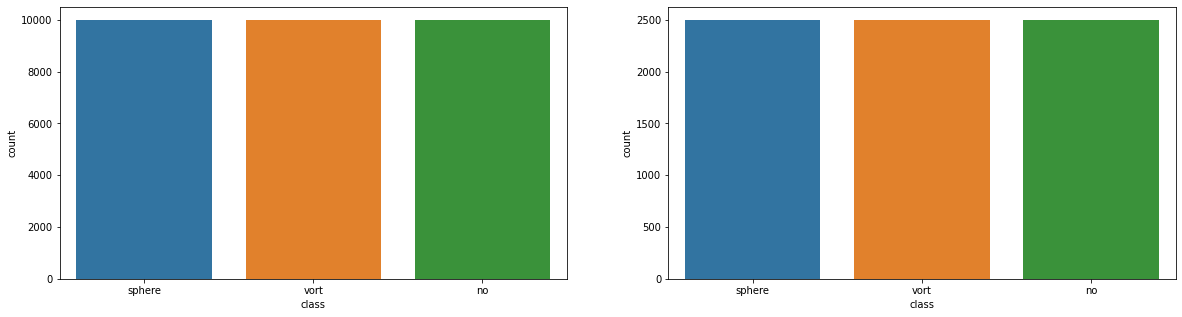

In [ ]:
root_path = 'dataset2/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = 'dataset2/train' #one more seg_train folder within
seg_test_folders = 'dataset2/val'
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    if folder !='.DS_Store':
      quantity_tr[folder] = len(os.listdir(seg_train_folders+'/'+folder))

for folder in os.listdir(seg_test_folders):
    if folder !='.DS_Store':
      quantity_te[folder] = len(os.listdir(seg_test_folders+'/'+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))

plt.show()

In [ ]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 30000 images belonging to 3 classes.
Found 7500 images belonging to 3 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)


{'no': 0, 'sphere': 1, 'vort': 2}
{0: 'no', 1: 'sphere', 2: 'vort'}


In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        image_ids = os.listdir(os.path.join(seg_train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

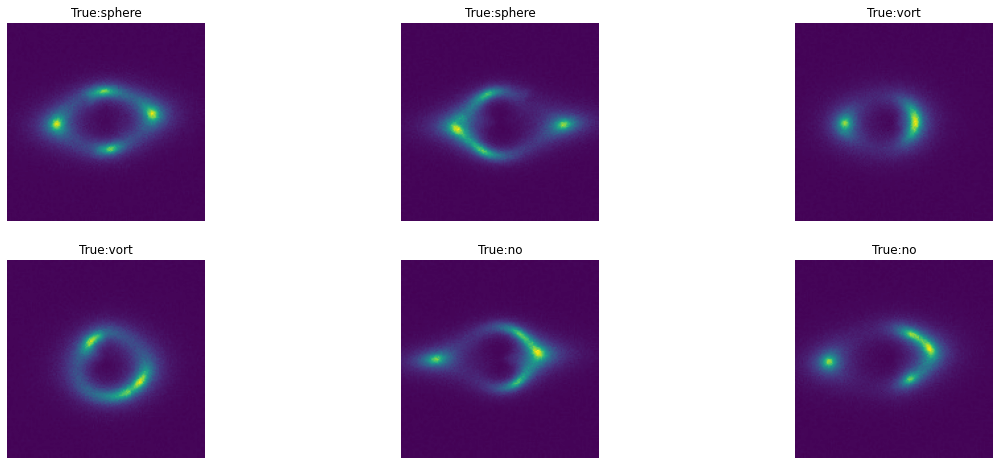

In [ ]:
show_few_images(2)

In [ ]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 60
vgg_epoch = 60
resnet_epoch = 60
inception_epoch = 60

In [ ]:
from kerastuner.tuners import RandomSearch

<ipython-input-20-94471a811b41>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
input_shape = (150, 150, 3)
num_classes = 3

def build_model(hp):
    base_model = InceptionV3(input_shape=input_shape,weights='imagenet', include_top=False)
    for layer in base_model.layers[:249]:
       layer.trainable = False
    for layer in base_model.layers[249:]:
       layer.trainable = True
    x = base_model.output
    x = Flatten()(x)
    x = Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu')(x)
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.5))(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3), momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_dir',
    project_name='inceptionv3_tuner')

inceptionv3_history = tuner.search(train_generator, validation_data=validation_generator, epochs=inception_epoch, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

best_model = tuner.get_best_models(num_models=1)[0]

Trial 1 Complete [01h 41m 14s]
val_accuracy: 0.5735999941825867

Best val_accuracy So Far: 0.5735999941825867
Total elapsed time: 01h 41m 14s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |352               |dense_units
0.4               |0.3               |dropout_rate
4.6239e-05        |0.0001117         |learning_rate

Epoch 1/60
938/938 [==============================] - 301s 315ms/step - loss: 1.1094 - accuracy: 0.3823 - val_loss: 1.0592 - val_accuracy: 0.4240
Epoch 2/60
938/938 [==============================] - 293s 313ms/step - loss: 1.0509 - accuracy: 0.4258 - val_loss: 1.0337 - val_accuracy: 0.4457
Epoch 3/60
938/938 [==============================] - 293s 313ms/step - loss: 1.0201 - accuracy: 0.4569 - val_loss: 1.0061 - val_accuracy: 0.4732
Epoch 4/60
938/938 [==============================] - 293s 312ms/step - loss: 0.9989 - accuracy: 0.4774 - val_loss: 1.0188 - val_accuracy: 0.4639
Epoch 5/60
938/938 [====================

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=3)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(3,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')


Epoch 1/60
938/938 [==============================] - ETA: 0s - loss: 1.1444 - acc: 0.3320
Epoch 1: val_acc improved from -inf to 0.33373, saving model to resnet50-saved-model-01-val_acc-0.33.hdf5
938/938 [==============================] - 354s 369ms/step - loss: 1.1444 - acc: 0.3320 - val_loss: 1.0992 - val_acc: 0.3337 - lr: 0.0100
Epoch 2/60
938/938 [==============================] - ETA: 0s - loss: 1.0992 - acc: 0.3342
Epoch 2: val_acc improved from 0.33373 to 0.33653, saving model to resnet50-saved-model-02-val_acc-0.34.hdf5
938/938 [==============================] - 347s 370ms/step - loss: 1.0992 - acc: 0.3342 - val_loss: 1.0987 - val_acc: 0.3365 - lr: 0.0100
Epoch 3/60
 77/938 [=>............................] - ETA: 4:49 - loss: 1.0986 - acc: 0.3295

KeyboardInterrupt: ignored

In [ ]:
# this could also be the output a different Keras model or layer
InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(192, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.4)(InceptionV3_x)
InceptionV3_x = Dense(3, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.00047321, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  



87910968/87910968 [==============================] - 3s 0us/step
Epoch 1/60
938/938 [==============================] - ETA: 0s - loss: 1.1253 - accuracy: 0.4051

938/938 [==============================] - 334s 349ms/step - loss: 1.1253 - accuracy: 0.4051 - val_loss: 1.0260 - val_accuracy: 0.4595
Epoch 2/60
938/938 [==============================] - ETA: 0s - loss: 1.0155 - accuracy: 0.4663

938/938 [==============================] - 325s 347ms/step - loss: 1.0155 - accuracy: 0.4663 - val_loss: 0.9856 - val_accuracy: 0.4956
Epoch 3/60
938/938 [==============================] - ETA: 0s - loss: 0.9762 - accuracy: 0.4998

938/938 [==============================] - 323s 344ms/step - loss: 0.9762 - accuracy: 0.4998 - val_loss: 0.9639 - val_accuracy: 0.5101
Epoch 4/60
938/938 [==============================] - ETA: 0s - loss: 0.9549 - accuracy: 0.5145

938/938 [==============================] - 320s 341ms/step - loss: 0.9549 - accuracy: 0.5145 - val_loss: 0.9860 - val_accuracy: 0.5007
Epoch 5/60
938/938 [==============================] - ETA: 0s - loss: 0.9324 - accuracy: 0.5328

938/938 [==============================] - 320s 341ms/step - loss: 0.9324 - accuracy: 0.5328 - val_loss: 1.0082 - val_accuracy: 0.4924
Epoch 6/60
938/938 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.5385

938/938 [==============================] - 327s 348ms/step - loss: 0.9221 - accuracy: 0.5385 - val_loss: 0.9349 - val_accuracy: 0.5325
Epoch 7/60
938/938 [==============================] - ETA: 0s - loss: 0.9074 - accuracy: 0.5490

938/938 [==============================] - 325s 347ms/step - loss: 0.9074 - accuracy: 0.5490 - val_loss: 0.9740 - val_accuracy: 0.5117
Epoch 8/60
938/938 [==============================] - ETA: 0s - loss: 0.8984 - accuracy: 0.5533

938/938 [==============================] - 331s 353ms/step - loss: 0.8984 - accuracy: 0.5533 - val_loss: 0.9071 - val_accuracy: 0.5413
Epoch 9/60
938/938 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.5657

938/938 [==============================] - 331s 354ms/step - loss: 0.8867 - accuracy: 0.5657 - val_loss: 0.9236 - val_accuracy: 0.5417
Epoch 10/60
938/938 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.5736

938/938 [==============================] - 328s 350ms/step - loss: 0.8790 - accuracy: 0.5736 - val_loss: 0.9015 - val_accuracy: 0.5592
Epoch 11/60
938/938 [==============================] - ETA: 0s - loss: 0.8697 - accuracy: 0.5796

938/938 [==============================] - 325s 347ms/step - loss: 0.8697 - accuracy: 0.5796 - val_loss: 0.9163 - val_accuracy: 0.5448
Epoch 12/60
938/938 [==============================] - ETA: 0s - loss: 0.8647 - accuracy: 0.5804

938/938 [==============================] - 321s 343ms/step - loss: 0.8647 - accuracy: 0.5804 - val_loss: 0.9428 - val_accuracy: 0.5367
Epoch 13/60
938/938 [==============================] - ETA: 0s - loss: 0.8509 - accuracy: 0.5886

938/938 [==============================] - 314s 335ms/step - loss: 0.8509 - accuracy: 0.5886 - val_loss: 0.9086 - val_accuracy: 0.5517
Epoch 14/60
938/938 [==============================] - ETA: 0s - loss: 0.8499 - accuracy: 0.5937

938/938 [==============================] - 315s 336ms/step - loss: 0.8499 - accuracy: 0.5937 - val_loss: 0.8762 - val_accuracy: 0.5675
Epoch 15/60
938/938 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.5957

938/938 [==============================] - 316s 337ms/step - loss: 0.8426 - accuracy: 0.5957 - val_loss: 0.8831 - val_accuracy: 0.5651
Epoch 16/60
938/938 [==============================] - ETA: 0s - loss: 0.8406 - accuracy: 0.5978

938/938 [==============================] - 335s 357ms/step - loss: 0.8406 - accuracy: 0.5978 - val_loss: 0.8741 - val_accuracy: 0.5715
Epoch 17/60
938/938 [==============================] - ETA: 0s - loss: 0.8338 - accuracy: 0.6054

938/938 [==============================] - 313s 334ms/step - loss: 0.8338 - accuracy: 0.6054 - val_loss: 0.8762 - val_accuracy: 0.5732
Epoch 18/60
938/938 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6048

938/938 [==============================] - 314s 335ms/step - loss: 0.8279 - accuracy: 0.6048 - val_loss: 0.9551 - val_accuracy: 0.5403
Epoch 19/60
938/938 [==============================] - ETA: 0s - loss: 0.8208 - accuracy: 0.6089

938/938 [==============================] - 333s 356ms/step - loss: 0.8208 - accuracy: 0.6089 - val_loss: 0.9643 - val_accuracy: 0.5341
Epoch 20/60
938/938 [==============================] - ETA: 0s - loss: 0.8177 - accuracy: 0.6151

938/938 [==============================] - 320s 342ms/step - loss: 0.8177 - accuracy: 0.6151 - val_loss: 0.8827 - val_accuracy: 0.5641
Epoch 21/60
938/938 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.6198

938/938 [==============================] - 313s 334ms/step - loss: 0.8119 - accuracy: 0.6198 - val_loss: 0.8865 - val_accuracy: 0.5731
Epoch 22/60
938/938 [==============================] - ETA: 0s - loss: 0.8135 - accuracy: 0.6182

938/938 [==============================] - 314s 335ms/step - loss: 0.8135 - accuracy: 0.6182 - val_loss: 0.8810 - val_accuracy: 0.5729
Epoch 23/60
938/938 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.6231

938/938 [==============================] - 312s 333ms/step - loss: 0.8040 - accuracy: 0.6231 - val_loss: 0.9485 - val_accuracy: 0.5476
Epoch 24/60
938/938 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.6229

938/938 [==============================] - 314s 335ms/step - loss: 0.7989 - accuracy: 0.6229 - val_loss: 0.8840 - val_accuracy: 0.5753
Epoch 25/60
938/938 [==============================] - ETA: 0s - loss: 0.7901 - accuracy: 0.6312

938/938 [==============================] - 314s 335ms/step - loss: 0.7901 - accuracy: 0.6312 - val_loss: 0.8691 - val_accuracy: 0.5824
Epoch 26/60
938/938 [==============================] - ETA: 0s - loss: 0.7927 - accuracy: 0.6275

938/938 [==============================] - 314s 335ms/step - loss: 0.7927 - accuracy: 0.6275 - val_loss: 0.8945 - val_accuracy: 0.5743
Epoch 27/60
938/938 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.6342

938/938 [==============================] - 312s 332ms/step - loss: 0.7895 - accuracy: 0.6342 - val_loss: 0.8793 - val_accuracy: 0.5816
Epoch 28/60
938/938 [==============================] - ETA: 0s - loss: 0.7786 - accuracy: 0.6344

938/938 [==============================] - 334s 356ms/step - loss: 0.7786 - accuracy: 0.6344 - val_loss: 0.8869 - val_accuracy: 0.5807
Epoch 29/60
938/938 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.6382

938/938 [==============================] - 315s 336ms/step - loss: 0.7748 - accuracy: 0.6382 - val_loss: 0.9195 - val_accuracy: 0.5632
Epoch 30/60
938/938 [==============================] - ETA: 0s - loss: 0.7715 - accuracy: 0.6415

938/938 [==============================] - 309s 330ms/step - loss: 0.7715 - accuracy: 0.6415 - val_loss: 0.9808 - val_accuracy: 0.5416
Epoch 31/60
938/938 [==============================] - ETA: 0s - loss: 0.7725 - accuracy: 0.6421

938/938 [==============================] - 314s 335ms/step - loss: 0.7725 - accuracy: 0.6421 - val_loss: 0.8533 - val_accuracy: 0.5823
Epoch 32/60
938/938 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.6437

938/938 [==============================] - 315s 336ms/step - loss: 0.7694 - accuracy: 0.6437 - val_loss: 0.9038 - val_accuracy: 0.5687
Epoch 33/60
938/938 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.6490

938/938 [==============================] - 319s 341ms/step - loss: 0.7643 - accuracy: 0.6490 - val_loss: 0.8712 - val_accuracy: 0.5935
Epoch 34/60
938/938 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.6486

938/938 [==============================] - 317s 338ms/step - loss: 0.7630 - accuracy: 0.6486 - val_loss: 0.9248 - val_accuracy: 0.5608
Epoch 35/60
938/938 [==============================] - ETA: 0s - loss: 0.7596 - accuracy: 0.6508

938/938 [==============================] - 336s 359ms/step - loss: 0.7596 - accuracy: 0.6508 - val_loss: 0.8799 - val_accuracy: 0.5860
Epoch 36/60
358/938 [==========>...................] - ETA: 2:00 - loss: 0.7521 - accuracy: 0.6567

In [ ]:
# this could also be the output a different Keras model or layer
InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(192, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.4)(InceptionV3_x)
InceptionV3_x = Dense(3, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
# InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])
InceptionV3_x_final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  



87910968/87910968 [==============================] - 6s 0us/step
Epoch 1/60
938/938 [==============================] - ETA: 0s - loss: 1.1832 - accuracy: 0.3853

938/938 [==============================] - 350s 348ms/step - loss: 1.1832 - accuracy: 0.3853 - val_loss: 1.1238 - val_accuracy: 0.3851
Epoch 2/60
938/938 [==============================] - ETA: 0s - loss: 1.0078 - accuracy: 0.4619

938/938 [==============================] - 336s 358ms/step - loss: 1.0078 - accuracy: 0.4619 - val_loss: 0.9631 - val_accuracy: 0.4860
Epoch 3/60
938/938 [==============================] - ETA: 0s - loss: 0.9800 - accuracy: 0.4869

938/938 [==============================] - 334s 356ms/step - loss: 0.9800 - accuracy: 0.4869 - val_loss: 1.1485 - val_accuracy: 0.3791
Epoch 4/60
938/938 [==============================] - ETA: 0s - loss: 0.9606 - accuracy: 0.5058

938/938 [==============================] - 310s 330ms/step - loss: 0.9606 - accuracy: 0.5058 - val_loss: 0.9451 - val_accuracy: 0.5091
Epoch 5/60
938/938 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.5224

938/938 [==============================] - 309s 330ms/step - loss: 0.9401 - accuracy: 0.5224 - val_loss: 0.9604 - val_accuracy: 0.4996
Epoch 6/60
938/938 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.5406

938/938 [==============================] - 307s 327ms/step - loss: 0.9234 - accuracy: 0.5406 - val_loss: 1.0446 - val_accuracy: 0.4867
Epoch 7/60
938/938 [==============================] - ETA: 0s - loss: 0.9116 - accuracy: 0.5474

938/938 [==============================] - 312s 333ms/step - loss: 0.9116 - accuracy: 0.5474 - val_loss: 0.8998 - val_accuracy: 0.5469
Epoch 8/60
938/938 [==============================] - ETA: 0s - loss: 0.8990 - accuracy: 0.5575

938/938 [==============================] - 313s 334ms/step - loss: 0.8990 - accuracy: 0.5575 - val_loss: 0.9246 - val_accuracy: 0.5360
Epoch 9/60
938/938 [==============================] - ETA: 0s - loss: 0.8878 - accuracy: 0.5638

938/938 [==============================] - 312s 333ms/step - loss: 0.8878 - accuracy: 0.5638 - val_loss: 0.8978 - val_accuracy: 0.5505
Epoch 10/60
938/938 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.5713

938/938 [==============================] - 312s 333ms/step - loss: 0.8796 - accuracy: 0.5713 - val_loss: 0.8931 - val_accuracy: 0.5549
Epoch 11/60
938/938 [==============================] - ETA: 0s - loss: 0.8726 - accuracy: 0.5740

938/938 [==============================] - 311s 332ms/step - loss: 0.8726 - accuracy: 0.5740 - val_loss: 0.9219 - val_accuracy: 0.5389
Epoch 12/60
938/938 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.5780

938/938 [==============================] - 308s 328ms/step - loss: 0.8690 - accuracy: 0.5780 - val_loss: 0.9995 - val_accuracy: 0.5025
Epoch 13/60
938/938 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.5803

938/938 [==============================] - 304s 325ms/step - loss: 0.8669 - accuracy: 0.5803 - val_loss: 0.9243 - val_accuracy: 0.5335
Epoch 14/60
938/938 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.5869

938/938 [==============================] - 328s 350ms/step - loss: 0.8605 - accuracy: 0.5869 - val_loss: 0.9341 - val_accuracy: 0.5395
Epoch 15/60
938/938 [==============================] - ETA: 0s - loss: 0.8539 - accuracy: 0.5907

938/938 [==============================] - 311s 332ms/step - loss: 0.8539 - accuracy: 0.5907 - val_loss: 0.9658 - val_accuracy: 0.5296
Epoch 16/60
938/938 [==============================] - ETA: 0s - loss: 0.8495 - accuracy: 0.5928

938/938 [==============================] - 309s 329ms/step - loss: 0.8495 - accuracy: 0.5928 - val_loss: 1.0173 - val_accuracy: 0.5185
Epoch 17/60
938/938 [==============================] - ETA: 0s - loss: 0.8428 - accuracy: 0.5965

938/938 [==============================] - 331s 353ms/step - loss: 0.8428 - accuracy: 0.5965 - val_loss: 0.9047 - val_accuracy: 0.5768
Epoch 18/60
938/938 [==============================] - ETA: 0s - loss: 0.8341 - accuracy: 0.6018

938/938 [==============================] - 301s 321ms/step - loss: 0.8341 - accuracy: 0.6018 - val_loss: 0.8767 - val_accuracy: 0.5744
Epoch 19/60
938/938 [==============================] - ETA: 0s - loss: 0.8295 - accuracy: 0.6024

938/938 [==============================] - 303s 323ms/step - loss: 0.8295 - accuracy: 0.6024 - val_loss: 0.8471 - val_accuracy: 0.5841
Epoch 20/60
938/938 [==============================] - ETA: 0s - loss: 0.8276 - accuracy: 0.6041

938/938 [==============================] - 304s 324ms/step - loss: 0.8276 - accuracy: 0.6041 - val_loss: 0.9339 - val_accuracy: 0.5507
Epoch 21/60
938/938 [==============================] - ETA: 0s - loss: 0.8197 - accuracy: 0.6132

938/938 [==============================] - 302s 322ms/step - loss: 0.8197 - accuracy: 0.6132 - val_loss: 0.8786 - val_accuracy: 0.5760
Epoch 22/60
938/938 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.6110

938/938 [==============================] - 310s 330ms/step - loss: 0.8189 - accuracy: 0.6110 - val_loss: 0.9243 - val_accuracy: 0.5560
Epoch 23/60
938/938 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.6188

938/938 [==============================] - 307s 328ms/step - loss: 0.8108 - accuracy: 0.6188 - val_loss: 0.9446 - val_accuracy: 0.5624
Epoch 24/60
938/938 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.6169

938/938 [==============================] - 304s 324ms/step - loss: 0.8107 - accuracy: 0.6169 - val_loss: 0.8658 - val_accuracy: 0.5897
Epoch 25/60
938/938 [==============================] - ETA: 0s - loss: 0.8055 - accuracy: 0.6180

938/938 [==============================] - 328s 350ms/step - loss: 0.8055 - accuracy: 0.6180 - val_loss: 0.8936 - val_accuracy: 0.5699
Epoch 26/60
938/938 [==============================] - ETA: 0s - loss: 0.8004 - accuracy: 0.6209

938/938 [==============================] - 304s 324ms/step - loss: 0.8004 - accuracy: 0.6209 - val_loss: 0.8700 - val_accuracy: 0.5845
Epoch 27/60
938/938 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.6237

938/938 [==============================] - 311s 331ms/step - loss: 0.7951 - accuracy: 0.6237 - val_loss: 0.9280 - val_accuracy: 0.5584
Epoch 28/60
 51/938 [>.............................] - ETA: 3:06 - loss: 0.7997 - accuracy: 0.6238

In [ ]:
from tensorflow.keras.models import load_model
from keras.optimizers import RMSprop
file_path = '/content/gdrive/MyDrive/data/model.h5'
# Load the pre-trained model from the HDF5 file
pretrained_model = load_model(file_path)

# Freeze the layers of the pre-trained model
for layer in pretrained_model.layers[:249]:
    layer.trainable = False
for layer in pretrained_model.layers[249:]:
    layer.trainable = True

# Add new layers on top of the pre-trained model
x = pretrained_model.output
x = Flatten(name="flatten_2")(x)
x = Dense(1024, activation='relu',name='dense1')(x)
x = Dropout(0.5,name='dropout_1')(x)
x = Dense(3, activation='softmax',name='dense')(x)

# Create the final model
model = Model(inputs=pretrained_model.input, outputs=x)

# Compile the model
# model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# optimizer = RMSprop(lr=0.001, rho=0.9)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up callbacks
# number_of_epochs = inception_epoch
# filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# # Train the model
# history = model.fit(train_generator, epochs=number_of_epochs, validation_data=validation_generator, callbacks=[checkpoint, early_stopping], verbose=1)

# # Do history stuff
# do_history_stuff(history, 'inceptionv3_model', True)


In [ ]:
import os
file='/content'
print(os.listdir(file))

['.config', 'dataset', 'dataset2', '__MACOSX', 'model.h5', 'gdrive', 'sample_data']


In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(3, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Substructure")

In [ ]:
tuner_search.search(train_generator, epochs=3, validation_data=validation_generator)



Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
128               |?                 |conv_1_filter
3                 |?                 |conv_1_kernel
32                |?                 |conv_2_filter
3                 |?                 |conv_2_kernel
80                |?                 |dense_1_units
0.001             |?                 |learning_rate

Epoch 1/3


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 266, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/base_tuner.py", line 231, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.wi

RuntimeError: ignored

In [ ]:
best_model.save('model_40.h5')

NameError: ignored

In [ ]:
model.save('/content/gdrive/MyDrive/data/model_60.h5')

NameError: ignored